In [1]:
import torch
import pandas as pd
import sklearn
import scprep
import numpy as np
from torch.utils.data import DataLoader
import matplotlib as plt
import matplotlib.font_manager
import sklearn.manifold
from tqdm import tqdm

# some matplotlib settings
%matplotlib inline
# It's also possible to use the reduced notation by directly setting font.family:
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica"
})

# get path
dataset = 'CelebA'
best_model_path = f"/home/thien/research/pseudogroups/{dataset}/splitpgl_sweep_logs/p0.5_wd0.0001_lr0.0001/part1_s0/best_model.pth"
data_path = f"/home/thien/research/pseudogroups/{dataset}/splitpgl_sweep_logs/p0.5_wd0.0001_lr0.0001/part1_s0/part1and2_data_p0.5"

device = 'cuda'

# load data splits
data = torch.load(data_path)
part1_data, part2_data = data['part1'], data['part2']
batch_size = 32

part1_loader = DataLoader(part1_data, shuffle=False, batch_size=batch_size, pin_memory=True)
part2_loader = DataLoader(part2_data, shuffle=False, batch_size=batch_size, pin_memory=True)


for p, pd in data.items():
    print( p, 'n=',len(pd))
    for group_idx in range(pd.n_groups):
        print(
            f'    {pd.group_str(group_idx)}: n = {pd.group_counts()[group_idx]:.0f}\n'
        )
        
group_to_name = {0: 'Non-blond Female', 1: 'Non-blond Male',
                2: 'Blond Female', 3: 'Blond Male'}

part1 n= 81385
    Blond_Hair = 0, Male = 0: n = 35831

    Blond_Hair = 0, Male = 1: n = 33466

    Blond_Hair = 1, Male = 0: n = 11406

    Blond_Hair = 1, Male = 1: n = 682

part2 n= 81385
    Blond_Hair = 0, Male = 0: n = 35798

    Blond_Hair = 0, Male = 1: n = 33408

    Blond_Hair = 1, Male = 0: n = 11474

    Blond_Hair = 1, Male = 1: n = 705



In [ ]:
# load model
model = torch.load(best_model_path)
model.to(device)
model.eval()

# make model save its features in 
activation = {}
def get_activation(name):
    def hook(model, inp, output):
#         print('inp\n\t', inp)
#         print('outp\n\t',output)
        activation[name] = inp[0].detach()
    return hook

model.fc.register_forward_hook(get_activation('fc'))


def get_feature_group(data_loader, model):
    
    feature_list = None
    group_list = None

    with torch.set_grad_enabled(False):
        for batch in tqdm(data_loader):
            batch = tuple(t.to(device) for t in batch)
            x, y, g, idx = batch
            outputs = model(x)
            features = activation['fc'].detach().cpu().numpy()

            # now save the group and features
            if feature_list is None:
                feature_list = features
                group_list = g.detach().cpu().numpy()
            else:
                feature_list = np.concatenate([feature_list, features])
                group_list = np.concatenate([group_list, g.detach().cpu().numpy()])

    group_label = []

    for g in group_list:
        group_label.append(group_to_name[g])
        
    return feature_list, group_list, group_label


In [ ]:
part1_feature_list, part1_group_list, part1_group_label = get_feature_group(part1_loader, model)
part2_feature_list, part2_group_list, part2_group_label = get_feature_group(part2_loader, model)

In [2]:
part1_feature_list, part1_group_list, part1_group_label = torch.load('/home/thien/research/pseudogroups/CelebA/part1_features_p0.5_s0')
part2_feature_list, part2_group_list, part2_group_label = torch.load('/home/thien/research/pseudogroups/CelebA/part2_features_p0.5_s0')


In [4]:
# part1_feature_list = np.array(part1_feature_list, dtype=np.float32)
# part2_feature_list = np.array(part2_feature_list, dtype=np.float32)
part1_feature_list.dtype

dtype('float32')

# TSNE

In [3]:
run_pca = True
subsample = True


if subsample:
    print('subsampling')
    part1_prep, part1_group_label_ss = scprep.select.subsample(part1_feature_list, part1_group_label, n=5000)
    part2_prep, part2_group_label_ss = scprep.select.subsample(part2_feature_list, part2_group_label, n=5000)
else:
    part1_prep = part1_feature_list
    part2_prep = part2_feature_list
    
# if run_pca:
#     print('running pca')
#     # reduce dimension to speed up TSNE
#     part1_prep = scprep.reduce.pca(part1_prep, n_components=100, method='dense')
#     part2_prep = scprep.reduce.pca(part2_prep, n_components=100, method='dense')

    

part1_gl = part1_group_label_ss if subsample else part1_group_label
part2_gl = part2_group_label_ss if subsample else part2_group_label


subsampling


In [12]:

def tsne_plot(part1_prep, part2_prep, part1_gl, part2_gl, perplexity):
    tsne_op = sklearn.manifold.TSNE(n_components=2, perplexity=perplexity)

    part1_tsne = tsne_op.fit_transform(part1_prep)
    part2_tsne = tsne_op.fit_transform(part2_prep)

    fig_size = (8,4)


    part1_tsne_plot = scprep.plot.scatter2d(part1_tsne, c=part1_gl,
                          figsize=fig_size, 
                          title='Features of Seen Examples',
                          ticks=False,)

    part2_tsne_plot = scprep.plot.scatter2d(part2_tsne, c=part2_gl,
                          figsize=fig_size, 
                          title='Features of Unseen Examples',
                          ticks=False,)
    part1_tsne_plot.figure.savefig(f'/home/thien/research/tsne_plot_{dataset}_seen_data_{perplexity}.eps', format='eps')
    part2_tsne_plot.figure.savefig(f'/home/thien/research/tsne_plot_{dataset}_unseen_data_{perplexity}.eps', format='eps')

perplexity 10
perplexity 70
perplexity 100


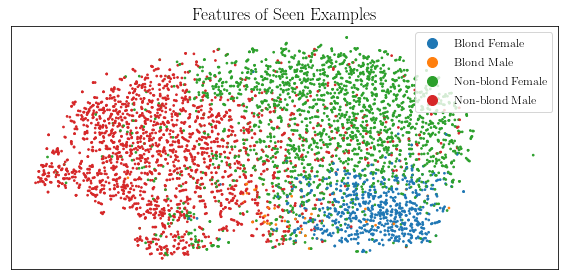

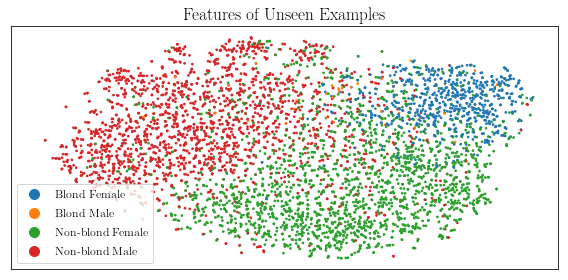

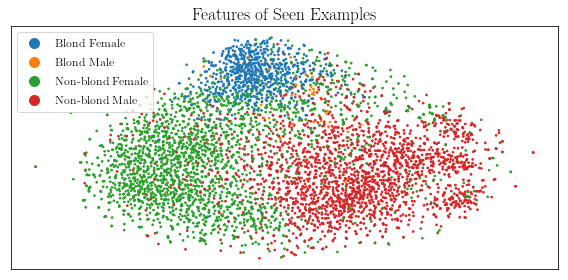

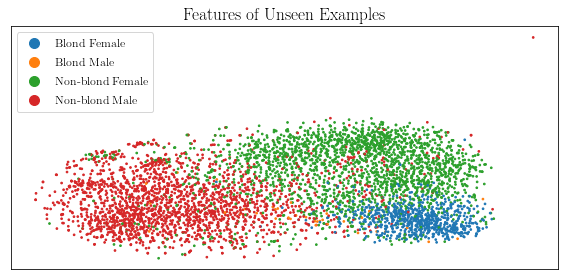

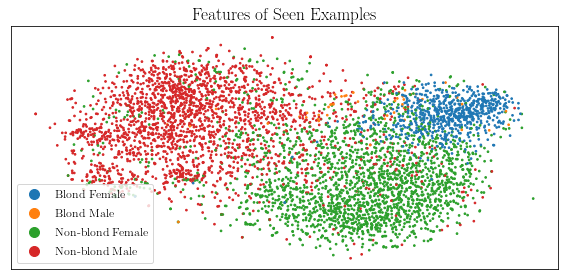

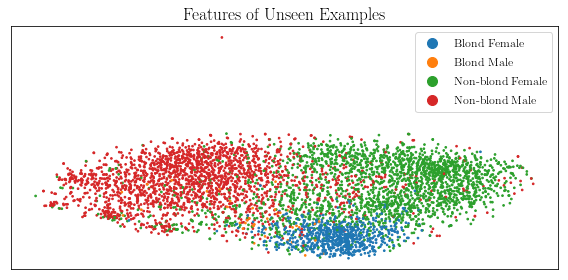

In [13]:
# perplexity set the size of the cluster
# perplexity = 50

for perplexity in [10, 70, 100]:
    print('perplexity', perplexity)
    tsne_plot(part1_prep, part2_prep, part1_gl, part2_gl, perplexity)

In [18]:
part1_tsne_plot.figure.show()

# PCA

In [ ]:
part1_pca = scprep.reduce.pca(part1_feature_list, n_components=2, method='dense')
part2_pca = scprep.reduce.pca(part2_feature_list, n_components=2, method='dense')

In [ ]:
fig_size = (8,4)

part1_pca_plot = scprep.plot.scatter2d(part1_pca, c=part1_group_label,
                      figsize=fig_size, 
                      title='Features of Seen Examples',
                      ticks=False,)

part2_pca_plot = scprep.plot.scatter2d(part2_pca, c=part2_group_label,
                      figsize=fig_size, 
                      title='Features of Unseen Examples',
                      ticks=False,)

In [ ]:
part1_pca_plot.figure.savefig(f'/home/thien/research/pca_plot_{dataset}_seen_data.eps', format='eps')
part2_pca_plot.figure.savefig(f'/home/thien/research/pca_plot_{dataset}_unseen_data.eps', format='eps')

# UMAP

In [19]:
import umap

nn = 9
def plot_umap(part1_feature_list, part2_feature_list, part1_group_label, part2_group_label, nn):
    umap_op = umap.UMAP(n_neighbors=nn, min_dist=0.15)

    part1_umap = umap_op.fit_transform(part1_feature_list)
    part2_umap = umap_op.fit_transform(part2_feature_list)
    fig_size = (8,4)

    part1_umap_plot = scprep.plot.scatter2d(part1_umap, c=part1_group_label,
                          figsize=fig_size, 
                          title='Features of Seen Examples',
                          ticks=False,)

    part2_umap_plot = scprep.plot.scatter2d(part2_umap, c=part2_group_label,
                          figsize=fig_size, 
                          title='Features of Unseen Examples',
                          ticks=False,)
    
    part1_umap_plot.figure.savefig(f'/home/thien/research/umap_plot_{dataset}_seen_data_{nn}.eps', format='eps')
    part2_umap_plot.figure.savefig(f'/home/thien/research/umap_plot_{dataset}_unseen_data_{nn}.eps', format='eps')

/home/thien/anaconda3/envs/spuriouscorr/lib/python3.6/site-packages/umap/spectral.py:349: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/home/thien/anaconda3/envs/spuriouscorr/lib/python3.6/site-packages/umap/spectral.py:349: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/home/thien/anaconda3/envs/spuriouscorr/lib/python3.6/site-packages/umap/spectral.py:349: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding so

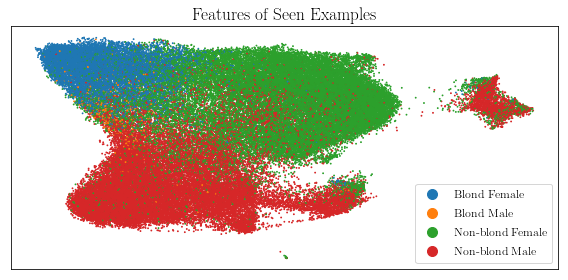

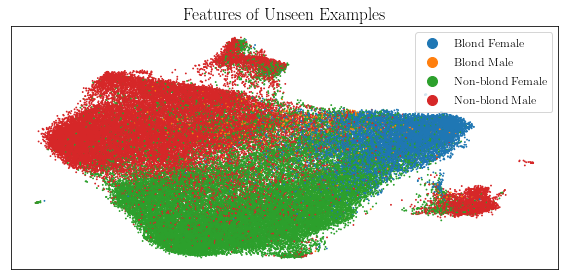

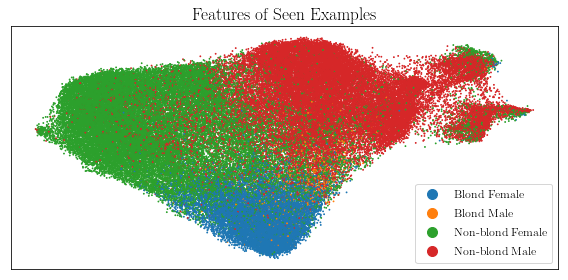

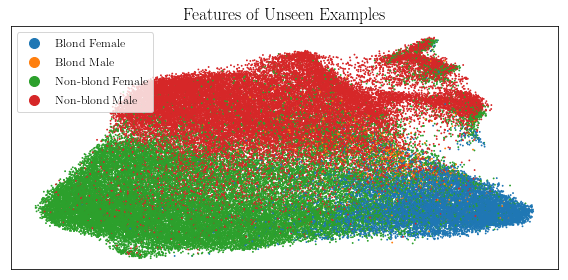

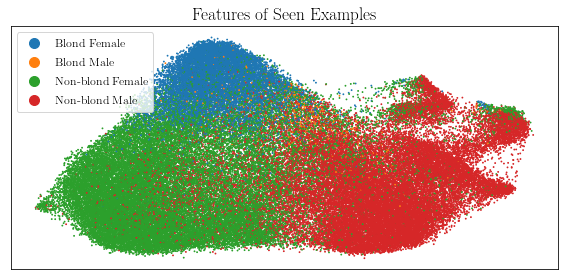

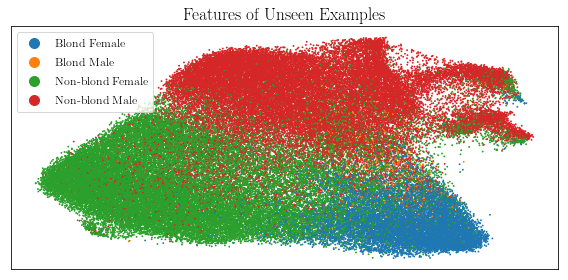

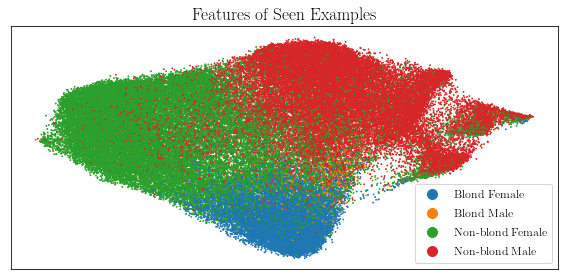

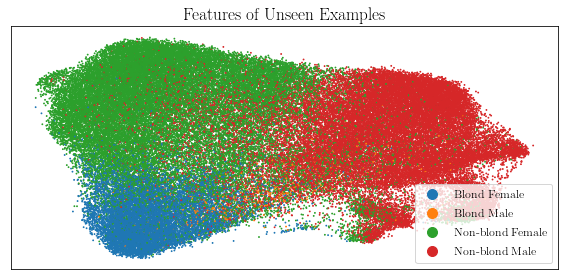

In [20]:
for nn in [10, 30, 50, 100]:
    print('nn', nn)
    plot_umap(part1_feature_list, part2_feature_list, part1_group_label, part2_group_label, nn)